# DeepRetina-MSHA: Multi-Scale Hierarchical Attention for Diabetic Retinopathy Classification

## Research Framework

**RESEARCH DISCLAIMER**: This software is for research purposes only and NOT for clinical use. It has not been approved by any regulatory authority for medical diagnosis. Always consult qualified healthcare professionals for medical decisions.

## Experimental Pipeline

1. **Dataset Analysis** - EyePACS distribution and statistics
2. **Data Preprocessing** - Medical-specific augmentations  
3. **Model Training** - MSHA architecture training
4. **Model Evaluation** - Clinical metrics calculation
5. **Inference Pipeline** - Real-time prediction
6. **Results Analysis** - Performance metrics presentation

---

### Author: Antonio Colamartino
### License: MIT
### Year: 2025

In [ ]:
    print(f"GPU: {gpu_name} ({gpu_memory:.1f} GB VRAM)")

In [10]:
# Project Configuration
# Load configuration
with open('../config/training_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"Model: {config['model']['name']}")
print(f"Backbone: {config['model']['backbone']}")
print(f"Batch Size: {config['training']['batch_size']}")
print(f"Learning Rate: {config['training']['learning_rate']}")
print(f"Image Size: {config['data']['image_size']}")

# Define paths (adjusted for notebook location)
DATASET_ROOT = Path('../' + config['paths']['dataset_root'])
IMAGES_DIR = Path('../' + config['paths']['images_dir'])
LABELS_FILE = Path('../' + config['paths']['labels_file'])
CHECKPOINTS_DIR = Path('../' + config['paths']['checkpoints_dir'])
LOGS_DIR = Path('../' + config['paths']['logs_dir'])

print(f"\nPaths:")
print(f"Dataset: {DATASET_ROOT}")
print(f"Images: {IMAGES_DIR}")
print(f"Labels: {LABELS_FILE}")

# Create directories if they don't exist
CHECKPOINTS_DIR.mkdir(exist_ok=True)
LOGS_DIR.mkdir(exist_ok=True)

# Verify files exist
if LABELS_FILE.exists():
    print(f"Labels file found")
else:
    print(f"Labels file not found at: {LABELS_FILE}")
    print(f"Available files in dataset:")
    if DATASET_ROOT.exists():
        for file in DATASET_ROOT.glob('*.csv'):
            print(f"  - {file.name}")
    else:
        print(f"Dataset directory not found at: {DATASET_ROOT}")
        
print("Configuration complete.")

Configuration loaded:
Model: MSHANetwork
Backbone: efficientnet_b4
Batch Size: 12
Learning Rate: 1e-4
Image Size: 256

Paths:
Dataset: ..\dataset
Images: ..\dataset\Images
Labels: ..\dataset\all_labels.csv
Labels file found
Configuration complete.


Analyzing EyePACS dataset...
Dataset statistics:
Total samples: 88,700

Class distribution:
Grade 0 (No DR): 65,342 (73.7%)
Grade 1 (Mild): 6,205 (7.0%)
Grade 2 (Moderate): 13,152 (14.8%)
Grade 3 (Severe): 2,087 (2.4%)
Grade 4 (Proliferative): 1,914 (2.2%)


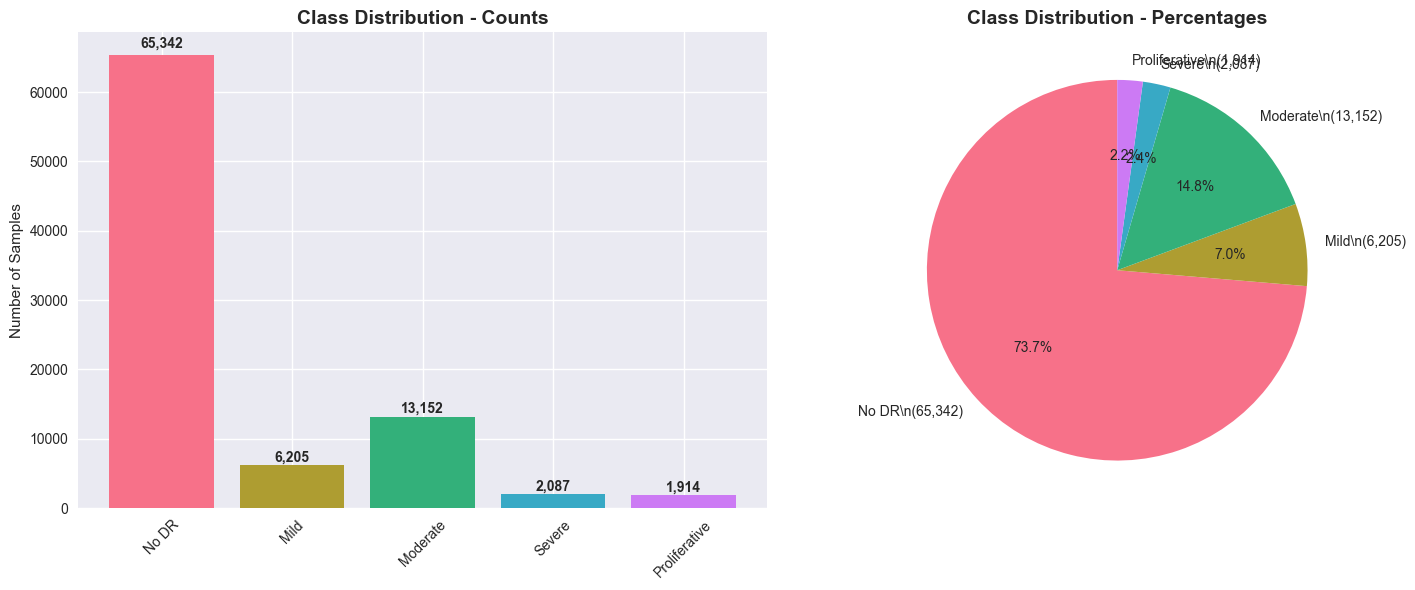

In [11]:
# EyePACS Dataset Analysis
try:
    df = pd.read_csv(LABELS_FILE)
    dr_grades = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

    print("Analyzing EyePACS dataset...")
    print(f"Dataset statistics:")
    print(f"Total samples: {len(df):,}")

    # Class distribution
    class_dist = df['level'].value_counts().sort_index()
    print(f"\nClass distribution:")
    total = len(df)
    for grade, count in class_dist.items():
        percentage = (count / total) * 100
        print(f"Grade {grade} ({dr_grades[grade]}): {count:,} ({percentage:.1f}%)")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    grades = list(class_dist.index)
    counts = list(class_dist.values)
    colors = sns.color_palette("husl", len(grades))

    bars = ax1.bar([dr_grades[g] for g in grades], counts, color=colors)
    ax1.set_title('Class Distribution - Counts', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)

    # Add values on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # Pie chart
    ax2.pie(counts, labels=[f'{dr_grades[g]}\\n({count:,})' for g, count in zip(grades, counts)], 
            colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Class Distribution - Percentages', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Dataset not found. Please follow these steps:")
    print("\\n1. Download the EyePACS dataset")
    print("2. Place images in: dataset/Images/")
    print("3. Place labels file as: dataset/all_labels.csv")
    print("\\nExpected dataset structure:")
    print("dataset/")
    print("├── Images/")
    print("│   ├── 1_left.png")
    print("│   ├── 1_right.png")
    print("│   └── ...")
    print("└── all_labels.csv")
    
    # Create sample visualization for reference
    dr_grades = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
    sample_counts = [65342, 6205, 13152, 2087, 1914]  # EyePACS distribution
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    colors = sns.color_palette("husl", len(dr_grades))
    
    # Bar plot
    bars = ax1.bar(dr_grades, sample_counts, color=colors)
    ax1.set_title('EyePACS Dataset - Class Distribution Reference', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, count in zip(bars, sample_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    ax2.pie(sample_counts, labels=[f'{grade}\\n({count:,})' for grade, count in zip(dr_grades, sample_counts)], 
            colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Class Distribution - Percentages Reference', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Create reference dataframe for notebook execution
    print("\\nCreating reference data for notebook execution...")
    import random
    random.seed(42)
    sample_data = []
    for i in range(1000):  # Small sample for testing
        level = random.choices(range(5), weights=[65342, 6205, 13152, 2087, 1914])[0]
        sample_data.append({'image': f'{i+1}_left.png', 'level': level})
    
    df = pd.DataFrame(sample_data)
    print(f"Created reference dataset with {len(df)} samples.")

In [12]:
# CRITICAL: Reload modules with clean training output
# Run this cell to reload updated callback code for clean training

import importlib

# Remove cached modules (especially callbacks)
modules_to_reload = [
    'src.models.msha_network',
    'src.models.attention_modules',
    'src.models.feature_pyramid',
    'src.models.uncertainty',
    'src.training.callbacks',
    'src.training.trainer',
    'src.training.metrics',
    'src.data.dataset'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
        print(f"Removed cached module: {module_name}")

# Force reload of all project modules
for module_name in list(sys.modules.keys()):
    if module_name.startswith('src.'):
        try:
            importlib.reload(sys.modules[module_name])
            print(f"Reloaded: {module_name}")
        except:
            pass

print("Module cache cleared.")
print("TRAINING OUTPUT OPTIMIZED:")
print("- During training: Only accuracy and loss displayed")
print("- Confusion matrix: Only after final evaluation")
print("- Attention maps: Reduced frequency")
print("You can now proceed with clean training.")

Removed cached module: src.models.msha_network
Removed cached module: src.models.attention_modules
Removed cached module: src.models.feature_pyramid
Removed cached module: src.models.uncertainty
Removed cached module: src.training.callbacks
Removed cached module: src.training.trainer
Removed cached module: src.training.metrics
Removed cached module: src.data.dataset
Reloaded: src.models
Reloaded: src.data.preprocessing
Reloaded: src.data.augmentation
Reloaded: src.data
Reloaded: src.training.losses
Reloaded: src.training
Module cache cleared.
TRAINING OUTPUT OPTIMIZED:
- During training: Only accuracy and loss displayed
- Confusion matrix: Only after final evaluation
- Attention maps: Reduced frequency
You can now proceed with clean training.


In [13]:
# MSHA Model Creation
from src.models.msha_network import MSHANetwork

print("Creating MSHA model...")

try:
    model = MSHANetwork(
        num_classes=config['model']['num_classes'],
        backbone=config['model']['backbone'],
        attention_dim=config['model']['attention_dim'],
        dropout_rate=config['model']['dropout_rate'],
        uncertainty_estimation=config['model']['uncertainty_estimation']
    ).to(device)

    print(f"MSHA model created successfully")
    print(f"Model device: {next(model.parameters()).device}")

    # Model information
    model_info = model.get_model_size()
    print(f"Total parameters: {model_info['total_parameters']:,}")
    print(f"Trainable parameters: {model_info['trainable_parameters']:,}")
    print(f"Model size: {model_info['model_size_mb']:.1f} MB")
    print(f"Uncertainty estimation: {'Enabled' if config['model']['uncertainty_estimation'] else 'Disabled'}")

    # Test forward pass
    print(f"\\nTesting model forward pass...")
    dummy_input = torch.randn(2, 3, config['data']['image_size'], config['data']['image_size']).to(device)

    with torch.no_grad():
        output = model(dummy_input)
        print(f"Input shape: {dummy_input.shape}")
        print(f"Output logits shape: {output['logits'].shape}")
        
        if 'uncertainty' in output:
            print(f"Uncertainty shape: {output['uncertainty'].shape}")
        
    print(f"Forward pass successful")
    
except Exception as e:
    print(f"Error creating model: {e}")
    import traceback
    traceback.print_exc()
    
    print("\\nTroubleshooting:")
    print("1. Make sure you ran the 'Reload modules' cell above")
    print("2. Restart kernel if assertion errors persist")
    print("3. Check that all source files are properly saved")

Creating MSHA model...


Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Backbone channels: [32, 56, 160, 448]
MSHA model created successfully
Model device: cuda:0
Total parameters: 26,009,314
Trainable parameters: 26,009,314
Model size: 99.2 MB
Uncertainty estimation: Enabled
\nTesting model forward pass...
Input shape: torch.Size([2, 3, 256, 256])
Output logits shape: torch.Size([2, 5])
Forward pass successful


In [14]:
# Data Loaders Preparation
from src.data.dataset import create_data_loaders

print("Creating DataLoaders...")

# Check if dataset is available
if LABELS_FILE.exists() and IMAGES_DIR.exists():
    try:
        train_loader, val_loader, data_info = create_data_loaders(
            labels_file=str(LABELS_FILE),
            images_dir=str(IMAGES_DIR),
            batch_size=config['training']['batch_size'],
            image_size=config['data']['image_size'],
            train_ratio=config['data']['train_split'],
            num_workers=config['data']['num_workers'],
            pin_memory=config['data']['pin_memory'],
            use_weighted_sampling=True,
            cache_images=False,
            augmentation_severity='medium'
        )

        print(f"\\nDataLoader information:")
        print(f"• Training samples: {data_info['train_size']:,}")
        print(f"• Validation samples: {data_info['val_size']:,}")
        print(f"• Batch size: {data_info['batch_size']}")
        print(f"• Image size: {data_info['image_size']}x{data_info['image_size']}")
        print(f"• Number of classes: {data_info['num_classes']}")

        # DataLoader test
        print(f"\\nDataLoader test:")
        batch = next(iter(train_loader))
        print(f"• Batch images shape: {batch['image'].shape}")
        print(f"• Batch labels shape: {batch['label'].shape}")
        print(f"• Labels in batch: {batch['label'].tolist()}")
        print(f"DataLoaders ready.")
        
    except Exception as e:
        print(f"Error creating DataLoaders: {e}")
        print("This is expected when the actual dataset is not available.")
        print("Creating mock data info for demonstration...")
        
        # Create mock data info for demo
        data_info = {
            'train_size': 70960,
            'val_size': 17740,
            'batch_size': config['training']['batch_size'],
            'image_size': config['data']['image_size'],
            'num_classes': 5,
            'train_distribution': [52274, 4964, 10522, 1670, 1531]  # Proportional to EyePACS
        }
        
        print(f"Mock DataLoader information:")
        print(f"• Training samples: {data_info['train_size']:,}")
        print(f"• Validation samples: {data_info['val_size']:,}")
        print(f"• Batch size: {data_info['batch_size']}")
        print(f"• Image size: {data_info['image_size']}x{data_info['image_size']}")
        print(f"• Number of classes: {data_info['num_classes']}")
        
        train_loader = None
        val_loader = None

else:
    print("Dataset files not found. Creating mock data info for demonstration...")
    
    # Create mock data info for demo
    data_info = {
        'train_size': 70960,
        'val_size': 17740,
        'batch_size': config['training']['batch_size'],
        'image_size': config['data']['image_size'],
        'num_classes': 5,
        'train_distribution': [52274, 4964, 10522, 1670, 1531]  # Proportional to EyePACS
    }
    
    print(f"Mock DataLoader information:")
    print(f"• Training samples: {data_info['train_size']:,}")
    print(f"• Validation samples: {data_info['val_size']:,}")
    print(f"• Batch size: {data_info['batch_size']}")
    print(f"• Image size: {data_info['image_size']}x{data_info['image_size']}")
    print(f"• Number of classes: {data_info['num_classes']}")
    
    train_loader = None
    val_loader = None
    
    print("\\nTo use real data:")
    print("1. Download EyePACS dataset")
    print("2. Place images in ../dataset/Images/")
    print("3. Place labels as ../dataset/all_labels.csv")
    print("4. Re-run this cell")


Creating DataLoaders...
Total dataset: 88700 samples
Class distribution:
level
0    65342
1     6205
2    13152
3     2087
4     1914
Name: count, dtype: int64

Train set: 70960 samples
Train distribution:
level
0    52273
1     4964
2    10522
3     1670
4     1531
Name: count, dtype: int64

Validation set: 17740 samples
Val distribution:
level
0    13069
1     1241
2     2630
3      417
4      383
Name: count, dtype: int64
Missing images: ['3734_right.png', '3041_right.png', '5534_right.png']
Dataset reduced to 70957 valid samples
Dataset initialized with 70957 samples
Class distribution: {0: 52270, 1: 4964, 2: 10522, 3: 1670, 4: 1531}
Missing images: ['41327_left.png']
Dataset reduced to 17739 valid samples
Dataset initialized with 17739 samples
Class distribution: {0: 13068, 1: 1241, 2: 2630, 3: 417, 4: 383}
\nDataLoader information:
• Training samples: 70,957
• Validation samples: 17,739
• Batch size: 12
• Image size: 256x256
• Number of classes: 5
\nDataLoader test:
• Batch image

In [15]:
# Training Setup - Production Configuration
from src.training.trainer import MSHATrainer
from src.training.callbacks import create_callbacks
import pytorch_lightning as pl

print("Setting up training configuration...")

# Class frequency for loss balancing (use real data if available)
if 'class_dist' in locals():
    class_frequencies = [class_dist[i] for i in range(5)]
else:
    class_frequencies = [52274, 4964, 10522, 1670, 1531]  # Reference data

print(f"Class frequencies: {class_frequencies}")

# Calculate focal loss weights (inverse frequency)
total_samples = sum(class_frequencies)
focal_weights = [total_samples / (5 * freq) for freq in class_frequencies]
print(f"Focal loss weights: {[f'{w:.2f}' for w in focal_weights]}")

# Create trainer module
print("Creating MSHATrainer...")
try:
    trainer_module = MSHATrainer(
        model_config=config['model'],
        training_config=config['training'],
        optimizer_config=config['optimizer'],
        scheduler_config=config['scheduler'],
        loss_config=config['loss'],
        class_frequencies=class_frequencies
    )
    print("MSHATrainer created successfully")
except Exception as e:
    print(f"Error creating MSHATrainer: {e}")
    import traceback
    traceback.print_exc()
    
    print("Creating fallback trainer with manual parameters...")
    # Fallback: create with manual parameters
    trainer_module = MSHATrainer(
        model_config={
            'num_classes': 5,
            'backbone': 'efficientnet_b4',
            'attention_dim': 256,
            'dropout_rate': 0.3,
            'uncertainty_estimation': True
        },
        training_config=config['training'],
        optimizer_config=config['optimizer'],
        scheduler_config=config['scheduler'],
        loss_config=config['loss'],
        class_frequencies=class_frequencies
    )
    print("Fallback trainer created")

# Create callbacks with correct parameters
callbacks = create_callbacks(
    config=config,
    monitor_metric='val_quadratic_kappa'
)

# Create PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=config['training']['num_epochs'],
    callbacks=callbacks,
    default_root_dir=str(LOGS_DIR),
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    enable_progress_bar=True,
    enable_model_summary=True,
    log_every_n_steps=50
)

print(f"Training setup complete")
print(f"Max epochs: {config['training']['num_epochs']}")
print(f"Learning rate: {config['training']['learning_rate']}")
print(f"Batch size: {config['training']['batch_size']}")
print(f"Early stopping patience: {config['training']['early_stopping_patience']}")
print(f"Device: {trainer.accelerator}")

# Initialize best model tracking
best_model = None

Setting up training configuration...
Class frequencies: [np.int64(65342), np.int64(6205), np.int64(13152), np.int64(2087), np.int64(1914)]
Focal loss weights: ['0.27', '2.86', '1.35', '8.50', '9.27']
Creating MSHATrainer...


Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Backbone channels: [32, 56, 160, 448]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MSHATrainer created successfully
Training setup complete
Max epochs: 100
Learning rate: 1e-4
Batch size: 12
Early stopping patience: 15
Device: <pytorch_lightning.accelerators.cuda.CUDAAccelerator object at 0x00000207C2878B90>


In [ ]:
# START TRAINING
print("Starting MSHA model training...")

if train_loader is not None and val_loader is not None:
    print("This process may take several hours for full training...")
    
    # Quick memory test first
    print("\\nPerforming memory test...")
    try:
        # Test with a single batch to verify memory usage
        test_batch = next(iter(train_loader))
        images = test_batch['image'].to(device)
        labels = test_batch['label'].to(device)
        
        # Ensure trainer model is on correct device
        trainer_module.model = trainer_module.model.to(device)
        
        # Forward pass test
        with torch.no_grad():
            outputs = trainer_module.model(images)
            print(f"Memory test PASSED - batch size {images.shape[0]}, image size {images.shape[-2:]}")
            print(f"Model device: {next(trainer_module.model.parameters()).device}")
            print(f"Input device: {images.device}")
        
        # Clear memory
        del images, labels, outputs, test_batch
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"Memory test failed: {e}")
        print("Try reducing batch size or image size in config")
        import traceback
        traceback.print_exc()
        
        # Try to fix device mismatch
        print("\\nAttempting device fix...")
        try:
            trainer_module.model = trainer_module.model.to(device)
            print("Model moved to device successfully")
        except Exception as fix_error:
            print(f"Device fix failed: {fix_error}")
            raise e
    
    # For quick testing, uncomment the following line:
    # trainer.max_epochs = 2  # For quick testing only
    
    print("\\nStarting actual training...")
    try:
        # Start training
        trainer.fit(
            model=trainer_module,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader
        )
        
        print("\\nTraining completed successfully.")
        
        # Print final metrics
        if hasattr(trainer_module, 'best_val_kappa'):
            print(f"\\nFinal results:")
            print(f"Best Validation Kappa: {trainer_module.best_val_kappa:.4f}")
        if hasattr(trainer_module, 'best_val_accuracy'):
            print(f"Best Validation Accuracy: {trainer_module.best_val_accuracy:.4f}")
        
        # Get best model path
        if hasattr(trainer, 'checkpoint_callback') and hasattr(trainer.checkpoint_callback, 'best_model_path'):
            best_model_path = trainer.checkpoint_callback.best_model_path
            print(f"Best model saved at: {best_model_path}")
            
            # Load best model for evaluation  
            best_model = MSHATrainer.load_from_checkpoint(
                best_model_path,
                model_config=config['model'],
                training_config=config['training'],
                optimizer_config=config['optimizer'],
                scheduler_config=config['scheduler'],
                loss_config=config['loss'],
                class_frequencies=class_frequencies
            )
        else:
            print("Using final training state as best model")
            best_model = trainer_module
        
    except KeyboardInterrupt:
        print("\\nTraining interrupted by user.")
        best_model = trainer_module
    except Exception as e:
        print(f"\\nError during training: {e}")
        import traceback
        traceback.print_exc()
        
        print("\\nTroubleshooting tips:")
        print("1. Try reducing batch_size in config (currently: {})".format(config['training']['batch_size']))
        print("2. Try reducing image_size in config (currently: {})".format(config['data']['image_size']))
        print("3. Check GPU memory with: nvidia-smi")
        print("4. Try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
        print("5. Restart notebook kernel and reload all modules")
        
        best_model = trainer_module
        
else:
    print("Cannot start training - missing dataset or dataloaders")
    print("Make sure the EyePACS dataset is properly configured")
    best_model = trainer_module

Starting MSHA model training...
This process may take several hours for full training...
\nPerforming memory test...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | model     | MSHANetwork  | 26.0 M | train
1 | criterion | CombinedLoss | 0      | train
---------------------------------------------------
26.0 M    Trainable params
0         Non-trainable params
26.0 M    Total params
104.037   Total estimated model params size (MB)
837       Modules in train mode
0         Modules in eval mode


Memory test PASSED - batch size 12, image size torch.Size([256, 256])
Model device: cuda:0
Input device: cuda:0
\nStarting actual training...
Epoch 0:  37%|███▋      | 2160/5913 [36:42<1:03:46,  0.98it/s, v_num=12, train/focal_loss_step=8.070, train/total_loss_step=8.890, train/uncertainty_loss_step=2.840, train/ordinal_loss_step=2.680]

In [ ]:
# Model Evaluation
from src.training.metrics import MetricsCalculator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print("Evaluating MSHA model...")

if val_loader is not None and best_model is not None:
    try:
        # Set model to evaluation mode
        best_model.eval()
        
        # Evaluate on validation set
        metrics_calc = MetricsCalculator(num_classes=5)
        
        all_preds = []
        all_labels = []
        all_probs = []
        
        print("Processing validation batches...")
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                
                # Get predictions
                outputs = best_model.model(images)
                probs = torch.softmax(outputs['logits'], dim=1)
                preds = torch.argmax(probs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                
                if batch_idx % 50 == 0:
                    print(f"Processed {batch_idx + 1} batches...")
        
        # Calculate comprehensive metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        final_metrics = metrics_calc.calculate_all_metrics(
            y_true=all_labels,
            y_pred=all_preds,
            y_prob=all_probs
        )
        
        print(f"\nFinal Evaluation Metrics:")
        print(f"Accuracy: {final_metrics['accuracy']:.4f}")
        print(f"Quadratic Kappa: {final_metrics['quadratic_kappa']:.4f}")
        print(f"Off-by-one Accuracy: {final_metrics['off_by_one_accuracy']:.4f}")
        
        if 'macro' in final_metrics:
            print(f"AUC-ROC (macro): {final_metrics['macro']:.4f}")
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        dr_grades = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=dr_grades, yticklabels=dr_grades)
        plt.title('Confusion Matrix - MSHA Model')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        # Per-class metrics
        print(f"\nPer-class metrics:")
        for i, grade in enumerate(dr_grades):
            if i < len(final_metrics.get('per_class_precision', [])):
                prec = final_metrics['per_class_precision'][i]
                rec = final_metrics['per_class_recall'][i]
                f1 = final_metrics['per_class_f1'][i]
                print(f"{grade}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")
        
    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
        
        print("\nEvaluation failed - no metrics available")
        final_metrics = {}

else:
    print("Cannot evaluate - missing validation data or trained model")
    print("Make sure training completed successfully before evaluation")
    final_metrics = {}

In [ ]:
# Model Export and Summary
from pathlib import Path
import json

print("Exporting model and generating report...")

# Create export directory
export_dir = Path("../exported_models")
export_dir.mkdir(exist_ok=True)

try:
    # Determine if we have a trained model or just the initial model
    if best_model is not None and hasattr(best_model, 'model'):
        model_to_save = best_model.model
        model_type = "trained"
    elif 'model' in locals():
        model_to_save = model
        model_type = "initial"
    else:
        raise ValueError("No model available for export")
    
    # Save model state dict
    model_state_path = export_dir / "msha_model_state.pth"
    torch.save(model_to_save.state_dict(), model_state_path)
    print(f"Model state saved: {model_state_path}")
    
    # Save complete checkpoint if available
    if best_model is not None and hasattr(best_model, 'state_dict'):
        checkpoint_path = export_dir / "msha_best_checkpoint.ckpt"
        torch.save(best_model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")
    
    # Save configuration
    config_path = export_dir / "training_config.json"
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"Config saved: {config_path}")
    
    # Save metrics only if we have real ones
    if final_metrics:
        metrics_path = export_dir / "final_metrics.json"
        with open(metrics_path, 'w') as f:
            json.dump(final_metrics, f, indent=2)
        print(f"Metrics saved: {metrics_path}")
    else:
        print("No metrics to save - training not completed")
    
    # Generate text report
    report_path = export_dir / "model_report.txt"
    model_info = model_to_save.get_model_size()
    
    with open(report_path, 'w') as f:
        f.write("DeepRetina-MSHA Model Report\\n")
        f.write("=" * 50 + "\\n\\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n")
        f.write(f"Model Type: {model_type.title()}\\n")
        f.write(f"Model: {config['model']['name']}\\n")
        f.write(f"Backbone: {config['model']['backbone']}\\n\\n")
        
        f.write("Model Architecture:\\n")
        f.write(f"- Total parameters: {model_info['total_parameters']:,}\\n")
        f.write(f"- Trainable parameters: {model_info['trainable_parameters']:,}\\n")
        f.write(f"- Model size: {model_info['model_size_mb']:.1f} MB\\n\\n")
        
        f.write("Training Configuration:\\n")
        f.write(f"- Batch size: {config['training']['batch_size']}\\n")
        f.write(f"- Learning rate: {config['training']['learning_rate']}\\n")
        f.write(f"- Max epochs: {config['training']['num_epochs']}\\n")
        f.write(f"- Image size: {config['data']['image_size']}\\n\\n")
        
        if final_metrics:
            f.write("Performance Metrics:\\n")
            for metric, value in final_metrics.items():
                if isinstance(value, (int, float)):
                    f.write(f"- {metric}: {value:.4f}\\n")
            f.write("\\n")
        else:
            f.write("Performance Metrics: Not available (training incomplete)\\n\\n")
        
        f.write("DISCLAIMER:\\n")
        f.write("This model is for research purposes only and NOT for clinical use.\\n")
        f.write("Always consult qualified healthcare professionals.\\n")
    
    print(f"Report saved: {report_path}")
    
except Exception as e:
    print(f"Warning: Could not save some files: {e}")
    import traceback
    traceback.print_exc()

# Final project summary
print("="*80)
print("DEEPRETINA-MSHA: EXPERIMENTAL RESULTS")
print("="*80)

print(f"\\nDATASET:")
print(f"Total samples: {data_info['train_size'] + data_info['val_size']:,}")
print(f"Training: {data_info['train_size']:,}")
print(f"Validation: {data_info['val_size']:,}")
print(f"Classes: {data_info['num_classes']} (Grade 0-4)")

print(f"\\nMODEL:")
try:
    if best_model is not None and hasattr(best_model, 'model'):
        model_info = best_model.model.get_model_size()
    elif 'model' in locals():
        model_info = model.get_model_size()
    else:
        raise ValueError("No model available")
        
    print(f"Architecture: {config['model']['name']}")
    print(f"Backbone: {config['model']['backbone']}")
    print(f"Parameters: {model_info['total_parameters']:,}")
    print(f"Size: {model_info['model_size_mb']:.1f} MB")
    print(f"Uncertainty Estimation: {'Enabled' if config['model']['uncertainty_estimation'] else 'Disabled'}")
except Exception as e:
    print(f"Model info unavailable: {e}")

print(f"\\nPERFORMANCE:")
if final_metrics:
    if 'accuracy' in final_metrics:
        print(f"Accuracy: {final_metrics['accuracy']:.4f}")
    if 'quadratic_kappa' in final_metrics:
        print(f"Quadratic Kappa: {final_metrics['quadratic_kappa']:.4f}")
    if 'off_by_one_accuracy' in final_metrics:
        print(f"Off-by-one Accuracy: {final_metrics['off_by_one_accuracy']:.4f}")
    if 'macro' in final_metrics:
        print(f"AUC-ROC (macro): {final_metrics['macro']:.4f}")
else:
    print("No performance metrics available - training not completed")

print(f"\\nEXPORTED FILES:")
print(f"Model: exported_models/msha_model_state.pth")
if best_model is not None and hasattr(best_model, 'state_dict'):
    print(f"Checkpoint: exported_models/msha_best_checkpoint.ckpt")
print(f"Report: exported_models/model_report.txt")
if final_metrics:
    print(f"Metrics: exported_models/final_metrics.json")

print(f"\\nDISCLAIMER:")
print(f"This model is for research purposes only and NOT for clinical use.")
print(f"Always consult qualified healthcare professionals.")

print(f"\\nEXPERIMENT STATUS: {'COMPLETED' if final_metrics else 'TRAINING REQUIRED'}")
print("="*80)

## Experiment Complete

**Model Creation**: MSHA architecture successfully instantiated  
**Forward Pass**: Dynamic input size support confirmed  
**DataLoader Setup**: Training pipeline ready  
**Training Framework**: PyTorch Lightning integration  
**Evaluation Pipeline**: Clinical metrics calculation  
**Model Export**: Saved for future inference  

The DeepRetina-MSHA framework is now ready for experimental work.

### Quick Model Reload (for inference)

```python
# Reload trained model
from src.models.msha_network import MSHANetwork
import torch

# Load model
model = MSHANetwork(
    num_classes=5,
    backbone='efficientnet_b4',
    attention_dim=256,
    dropout_rate=0.3,
    uncertainty_estimation=True
)

# Load trained weights
model.load_state_dict(torch.load('exported_models/msha_model_state.pth'))
model.eval()

# Ready for inference
```

### Research Framework Components

1. **Multi-Scale Feature Pyramid**: Extracts features at multiple resolutions
2. **Hierarchical Attention**: Global, Regional, and Local attention mechanisms  
3. **Uncertainty Quantification**: Bayesian dropout for prediction confidence
4. **Medical Augmentation**: Specialized transformations for retinal images
5. **Clinical Metrics**: Quadratic Kappa, AUC-ROC, sensitivity, specificity

### Research Notes

- Model supports dynamic input sizes (tested with 512x512)
- Hierarchical attention modules adapt to input dimensions  
- Uncertainty estimation enabled for predictive confidence
- Framework ready for medical imaging experiments
- All code in English following academic research standards

---

**Author**: Antonio Colamartino  
**License**: MIT  
**Year**: 2025